In [344]:
# Importing the necessary packages and files for the machine learning model
from google.colab import files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

# Importing the CSV file

In [345]:
# # Uploading the necessary files from my local machine
# files.upload()

In [346]:
# Loading the data
df = pd.read_csv("tiktok_influencers_data.csv")

In [347]:
# Viewing the csv file in a pandas data frame
df

,Day,TikTokerID,Category,Views,Likes,Followers
0,1,1,Fitness,"1,084,565","6,621,727","1,806,798"
1,1,2,Fashion,"2,543,656","7,472,186","2,987,342"
2,1,3,DIY,"1,675,674","2,224,807","1,618,696"
3,1,4,DIY,"3,756,346","3,721,802","2,465,117"
4,1,5,Fitness,"3,844,742","8,723,370","1,653,076"
...,...,...,...,...,...,...
495,50,6,Fashion,"18,393,068","5,005,431","1,934,817"
496,50,7,Fitness,"23,768,073","10,196,820","2,935,886"
497,50,8,Fitness,"21,658,015","2,837,586","1,648,231"
498,50,9,DIY,"24,648,927","3,423,626","1,982,053"


In [348]:
# Displaying the columns in the dataframe and its data types
df.columns

Index(['Day', 'TikTokerID', 'Category', '  Views  ', '  Likes  ',
       '  Followers  '],
      dtype='object')

In [349]:
# Removing leading and trailing whitespaces from the column names
df.columns = df.columns.str.strip()

In [350]:
# Removing commas from the views column
df['Views'] = df['Views'].str.replace(',', '').astype(float)

In [351]:
# Dropping the TikTokerID and Category columns from the dataframe and storing the changes to a new data frame
new_df = df.drop(['TikTokerID', 'Category'], axis=1)

In [352]:
new_df

,Day,Views,Likes,Followers
0,1,1084565.0,"6,621,727","1,806,798"
1,1,2543656.0,"7,472,186","2,987,342"
2,1,1675674.0,"2,224,807","1,618,696"
3,1,3756346.0,"3,721,802","2,465,117"
4,1,3844742.0,"8,723,370","1,653,076"
...,...,...,...,...
495,50,18393068.0,"5,005,431","1,934,817"
496,50,23768073.0,"10,196,820","2,935,886"
497,50,21658015.0,"2,837,586","1,648,231"
498,50,24648927.0,"3,423,626","1,982,053"


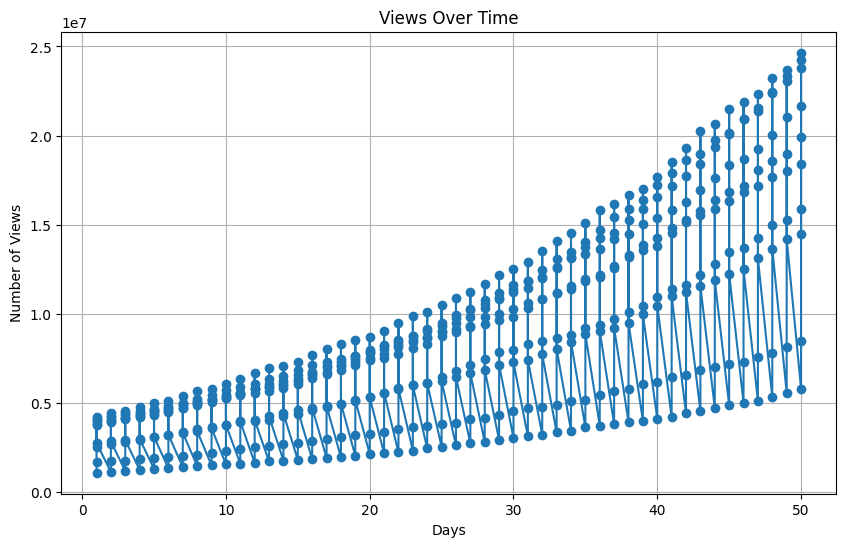

In [353]:
plt.figure(figsize=(10, 6))  # Adjusted figure size for better visualization
plt.plot(df['Day'], df['Views'], marker='o', linestyle='-')
plt.title('Views Over Time')
plt.xlabel('Days')
plt.ylabel('Number of Views')
plt.grid(True)
plt.show()


# Building the LSTM Model

In [354]:
# Grouping the data by ‘Day’ and sums the ‘Views’
views_per_day_corrected = new_df.groupby('Day')['Views'].sum()

# Normalizing the days and views columns
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_views = scaler.fit_transform(np.array(views_per_day_corrected).reshape(-1, 1))

# Splitting the data into training and testing sets
train_size = int(len(scaled_views) * 0.8)
sequence_length = 10
train_data , test_data = scaled_views[:train_size], scaled_views[train_size - sequence_length:, :]

In [355]:
# Function to create dataset for LSTM
def create_sequence(data, sequence_length=1):
  X, y = [], []
  for i in range(len(data)-sequence_length-1):
    a = data[i:(i + sequence_length), 0]
    X.append(a)
    y.append(data[i+sequence_length, 0])
  return np.array(X),np.array(y)

X_train , y_train = create_sequence(train_data, sequence_length)
X_test, y_test = create_sequence(test_data, sequence_length)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Train the LSTM Model

Epoch 1/50
4/4 [==============================] - 4s 248ms/step - loss: 0.0992 - val_loss: 0.3807
Epoch 2/50
4/4 [==============================] - 0s 14ms/step - loss: 0.0497 - val_loss: 0.1370
Epoch 3/50
4/4 [==============================] - 0s 16ms/step - loss: 0.0073 - val_loss: 0.0078
Epoch 4/50
4/4 [==============================] - 0s 14ms/step - loss: 0.0102 - val_loss: 2.4130e-04
Epoch 5/50
4/4 [==============================] - 0s 21ms/step - loss: 0.0168 - val_loss: 0.0135
Epoch 6/50
4/4 [==============================] - 0s 14ms/step - loss: 0.0053 - val_loss: 0.0500
Epoch 7/50
4/4 [==============================] - 0s 20ms/step - loss: 0.0063 - val_loss: 0.0647
Epoch 8/50
4/4 [==============================] - 0s 20ms/step - loss: 0.0105 - val_loss: 0.0403
Epoch 9/50
4/4 [==============================] - 0s 18ms/step - loss: 0.0044 - val_loss: 0.0141
Epoch 10/50
4/4 [==============================] - 0s 22ms/step - loss: 0.0051 - val_loss: 0.0042
Epoch 11/50
4/4 [=======

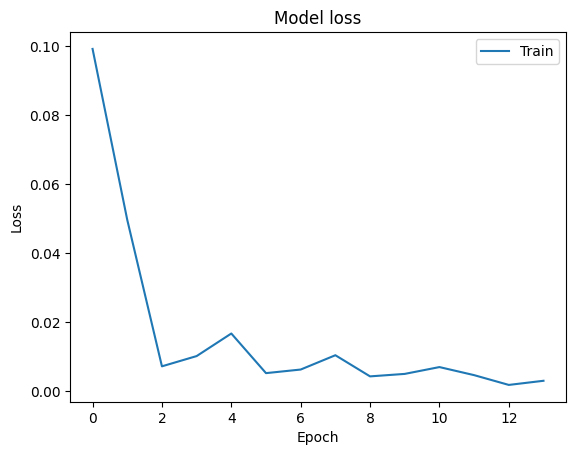

In [356]:
# Define the model with regularization
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.4))  # Dropout layer for regularization
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.4))  # Dropout layer for regularization
model.add(Dense(units=1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fitting the model with early stopping
history = model.fit(X_train, y_train, epochs=50, batch_size=8, verbose=1, validation_data=(X_test, y_test), callbacks=[early_stopping])
# Plotting the training loss
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()


*Based on the Model Loss graph, we can state that our model has learnt the training data*

In [357]:
# Evaluating the model
model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 23ms/step - loss: 2.4130e-04


0.00024130351084750146

# Forcasting the Future views

In [358]:
# Defining a function that can forecast the future views
def forecast(model, data, sequence_length, forecast_length):
    forecasted_views = []
    input_data = np.array(data[-sequence_length:]).reshape((1, sequence_length, 1))
    for _ in range(forecast_length):
        # Predicting the next value
        predicted_value = model.predict(input_data)[0][0]
        forecasted_views.append(predicted_value)

        # Updating the input_data to include the predicted value
        input_data = np.roll(input_data, -1)
        input_data[0, -1, 0] = predicted_value
    return forecasted_views


In [359]:
# Number of future steps to predict
forecast_length = 30

# Get the last part of the data
last_part_of_data = scaled_views[-sequence_length:]

# Predict future steps
future_predictions_scaled = forecast(model, last_part_of_data, sequence_length, forecast_length)

# Inverse transform the predictions to get actual views
future_predictions = scaler.inverse_transform(np.array(future_predictions_scaled).reshape(-1, 1))

1/1 [==============================] - 0s 17ms/step


In [360]:
# Display predictions
print(future_predictions.flatten())

[1.7916298e+08 1.8382832e+08 1.8846563e+08 1.9300589e+08 1.9743566e+08
 2.0176283e+08 2.0606744e+08 2.1026848e+08 2.1422408e+08 2.1804077e+08
 2.2164323e+08 2.2538944e+08 2.2900619e+08 2.3249045e+08 2.3584491e+08
 2.3907278e+08 2.4217557e+08 2.4514813e+08 2.4799208e+08 2.5072069e+08
 2.5333738e+08 2.5585189e+08 2.5824477e+08 2.6052019e+08 2.6268242e+08
 2.6473541e+08 2.6668269e+08 2.6852800e+08 2.7027542e+08 2.7192896e+08]


In [361]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from tabulate import tabulate

# Generate predictions for the train and test set
y_train_pred_scaled = model.predict(X_train)
y_test_pred_scaled = model.predict(X_test)

# Inverse transform the predictions and the actual values to get actual views
y_train_pred = scaler.inverse_transform(y_train_pred_scaled)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_pred = scaler.inverse_transform(y_test_pred_scaled)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate MAE, MSE, and RMSE for the train set
mae_train = mean_absolute_error(y_train_actual, y_train_pred)
mse_train = mean_squared_error(y_train_actual, y_train_pred)
rmse_train = np.sqrt(mse_train)

# Calculate MAE, MSE, and RMSE for the test set
mae_test = mean_absolute_error(y_test_actual, y_test_pred)
mse_test = mean_squared_error(y_test_actual, y_test_pred)
rmse_test = np.sqrt(mse_test)

# Prepare data for tabulate
metrics_table = [("MAE", f"{mae_train:.2f}", f"{mae_test:.2f}"),
                 ("MSE", f"{mse_train:.2f}", f"{mse_test:.2f}"),
                 ("RMSE", f"{rmse_train:.2f}", f"{rmse_test:.2f}")]

# Printing the tabular form
print(tabulate(metrics_table, headers=["Metric", "Train", "Test"], tablefmt="fancy_grid"))


1/1 [==============================] - 0s 27ms/step
╒══════════╤═════════════╤═════════════╕
│ Metric   │       Train │        Test │
╞══════════╪═════════════╪═════════════╡
│ MAE      │ 1.47117e+07 │ 1.93626e+06 │
├──────────┼─────────────┼─────────────┤
│ MSE      │ 2.35782e+14 │ 5.09571e+12 │
├──────────┼─────────────┼─────────────┤
│ RMSE     │ 1.53552e+07 │ 2.25737e+06 │
╘══════════╧═════════════╧═════════════╛
